In [1]:
import numpy as np
import pandas as pd
import random
import tqdm
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt
import seaborn as sns 
import yaml
from pathlib import Path
import sys 
import os 
sys.path.append(os.path.dirname(os.getcwd()))
from util.functions import logistic
from structure_generation.path_connection_gen import ProceduralGraphGenerator, StatsUtils, GraphStructureGenerator




In [2]:
geometric_graph_conf = yaml.safe_load(Path('config.yml').read_text())['reachability']

In [3]:
geometric_graph_conf

{'num_simulation_runs_geometric': 30,
 'num_simulation_runs_barabassi': 30,
 'mean_degrees': [5],
 'nodes': 750,
 'structure_names': ['random_geometric', 'barabasi_albert']}

In [4]:
import multiprocessing, itertools
from typing import Union, Optional, Tuple, List
import networkx as nx 

In [5]:
def run_single_simulation(
    passed_inputs, 
    verbose : bool =  False 
    ):
    """
    Function to run one iteration of the simulation. Need to pass a list instead of arguments to function 
    is so that it can work with pmap.unordered
    """
    mean_degree, structure_name, number_nodes = passed_inputs
    results_dict_irreversable, results_dict_reversable, results_dict_probability = {}, {}, {}
    if verbose: 
        print(f"simulation run for degree {mean_degree}")
    graphgen = GraphStructureGenerator(
        structure_name=structure_name, 
        num_nodes=number_nodes, 
        target_mean_degree = mean_degree
    )
    graph = graphgen.initial_graph  

    x = ProceduralGraphGenerator(graph, num_nodes= graph.number_of_nodes())
    infection_matrix_list_irreversable, timesteps_saturation_irreversable, fraction_infected_list_irreversable, info_dict_irreversable = x.infect_till_saturation(
        structure_name = structure_name, modality="irreversable", verbose= False
    )
    infection_matrix_list_reversable, timesteps_saturation_reversable, fraction_infected_list_reversable, info_dict_reversable = x.infect_till_saturation(
        structure_name = structure_name, modality="reversable", verbose= False
    )
    infection_matrix_list_prob, timesteps_saturation_prob, fraction_infected_list_prob, info_dict_prob = x.infect_till_saturation(
        structure_name = structure_name, modality="irreversable", verbose= False, infection_probability= 0.005, sample_giant= False
    )

    results_dict_irreversable["infection_matrix"] = infection_matrix_list_irreversable
    results_dict_irreversable["timesteps_saturation"] = timesteps_saturation_irreversable
    results_dict_irreversable["fraction_infected_list"] = fraction_infected_list_irreversable
    results_dict_irreversable["info_dict"] = info_dict_irreversable

    results_dict_reversable["infection_matrix"] = infection_matrix_list_reversable
    results_dict_reversable["timesteps_saturation"] = timesteps_saturation_reversable
    results_dict_reversable["fraction_infected_list"] = fraction_infected_list_reversable
    results_dict_reversable["info_dict"] = info_dict_reversable

    results_dict_probability["infection_matrix"] = infection_matrix_list_prob
    results_dict_probability["timesteps_saturation"] = timesteps_saturation_prob
    results_dict_probability["fraction_infected_list"] = fraction_infected_list_prob
    results_dict_probability["info_dict"] = info_dict_prob

    return results_dict_reversable, results_dict_irreversable, results_dict_probability
    
def run_simulation(mean_degree : int, structure_name : str) -> list: 
    num_runs = {
        "random_geometric" : geometric_graph_conf['num_simulation_runs_geometric'],
        "barabasi_albert" : geometric_graph_conf['num_simulation_runs_barabassi'],

    }[structure_name]
    simulation_run_reversable, simulation_run_irreversable, simulation_run_prob = [], [], []
    with multiprocessing.Pool(processes=multiprocessing.cpu_count()- 1) as p:
        iterThis = itertools.repeat(
            [
                mean_degree, 
                structure_name,
                geometric_graph_conf['nodes']
            ],
            num_runs,
        )
        with tqdm.tqdm(total=num_runs) as pbar:
            for _ in p.imap_unordered(run_single_simulation, iterThis):
                pbar.update()
                simulation_run_reversable.append(_[0])
                simulation_run_irreversable.append(_[1])
                simulation_run_prob.append(_[2])

    final_dict_reversable = {k : [] for k in list(_[0].keys())}
    for key in final_dict_reversable.keys():
        for simulation_dict in simulation_run_reversable: 
            final_dict_reversable[key].append(simulation_dict[key])

    final_dict_irreversable = {k : [] for k in list(_[0].keys())}
    for key in final_dict_irreversable.keys():
        for simulation_dict in simulation_run_irreversable: 
            final_dict_irreversable[key].append(simulation_dict[key])

    final_dict_prob = {k : [] for k in list(_[0].keys())}
    for key in final_dict_prob.keys():
        for simulation_dict in simulation_run_irreversable: 
            final_dict_prob[key].append(simulation_dict[key])


    return final_dict_reversable, final_dict_irreversable, final_dict_prob

def plot_results(results_dict : dict, structure_name : str, xlim_range = None):
    num_nodes_run = [x['num_nodes'] for x in results_dict['info_dict']]
    average_node_num = np.average(num_nodes_run)
    std_node_num = np.std(num_nodes_run)
    
    average_nodes_final = []
    for i, iter in enumerate(results_dict['fraction_infected_list']):
        if structure_name == "random_geometric":
            if average_node_num-(std_node_num/2) <= results_dict['info_dict'][i]['num_nodes'] <= average_node_num+(std_node_num/2):
                timesteps_list = [x for x in range(len(iter))]
                plt.plot(timesteps_list, iter,)#label = f"average simulated saturation across {len(result['timesteps_saturation'])} runs")
                average_nodes_final.append(results_dict['info_dict'][i]['num_nodes'])
            else:
                print(f"dropping run number {i} due to insufficient nodes in the giant component")
        
    print("average num nodes", np.average(average_nodes_final), "std : ", np.std(average_nodes_final))
    if xlim_range: 
        plt.xlim(xlim_range)
    plt.title(f"saturation curve for {structure_name}     modality: {results_dict['info_dict'][0]['modality']}    mean degree: {round(results_dict['info_dict'][0]['average_degree'], 2)}")
    plt.xlabel("number simulation timesteps")
    plt.ylabel("fraction of giant graph infected")
    plt.legend()
    plt.show()

REVERSABLE GEOMETRIC GRAPH SIMULATION

In [6]:
graph_name = "random_geometric"
for degree in geometric_graph_conf['mean_degrees']: 
    print(f"simulation run for mean degree {degree}")
    simulation_run = run_simulation(degree, graph_name)

simulation run for mean degree 5


100%|██████████| 30/30 [14:56<00:00, 29.89s/it]  


In [7]:
for mode in simulation_run:
    print([mode['info_dict'][x]['average_degree'] for x in range(len(simulation_run[0]['info_dict']))], "\n")

[5.52988047808765, 5.306559571619813, 5.413043478260869, 5.714285714285714, 5.328894806924101, 5.625, 5.446313065976714, 5.291611185086551, 5.520639147802929, 5.437751004016064, 5.415670650730411, 5.689839572192513, 5.376486129458389, 5.683089214380826, 5.308510638297872, 5.430851063829787, 5.2443257676902535, 5.6955941255006675, 5.874163319946453, 5.718459495351926, 5.539491298527443, 5.475234270414993, 5.74468085106383, 5.144, 5.767068273092369, 5.820615796519411, 5.790172642762284, 5.48738379814077, 5.684491978609626, 5.597869507323568] 

[5.52988047808765, 5.306559571619813, 5.413043478260869, 5.714285714285714, 5.328894806924101, 5.625, 5.446313065976714, 5.291611185086551, 5.520639147802929, 5.437751004016064, 5.415670650730411, 5.689839572192513, 5.376486129458389, 5.683089214380826, 5.308510638297872, 5.430851063829787, 5.2443257676902535, 5.6955941255006675, 5.874163319946453, 5.718459495351926, 5.539491298527443, 5.475234270414993, 5.74468085106383, 5.144, 5.767068273092369, 

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


dropping run number 1 due to insufficient nodes in the giant component
dropping run number 2 due to insufficient nodes in the giant component
dropping run number 6 due to insufficient nodes in the giant component
dropping run number 9 due to insufficient nodes in the giant component
dropping run number 12 due to insufficient nodes in the giant component
dropping run number 18 due to insufficient nodes in the giant component
dropping run number 20 due to insufficient nodes in the giant component
dropping run number 21 due to insufficient nodes in the giant component
dropping run number 24 due to insufficient nodes in the giant component
dropping run number 25 due to insufficient nodes in the giant component
average num nodes 751.05 std :  1.6575584454250776


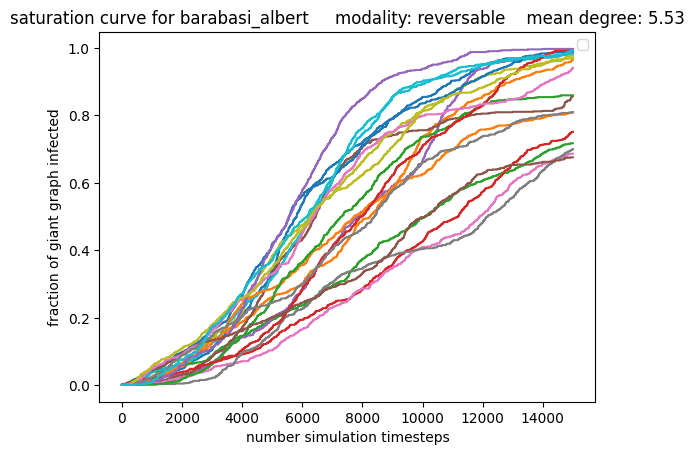

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


dropping run number 1 due to insufficient nodes in the giant component
dropping run number 2 due to insufficient nodes in the giant component
dropping run number 6 due to insufficient nodes in the giant component
dropping run number 9 due to insufficient nodes in the giant component
dropping run number 12 due to insufficient nodes in the giant component
dropping run number 18 due to insufficient nodes in the giant component
dropping run number 20 due to insufficient nodes in the giant component
dropping run number 21 due to insufficient nodes in the giant component
dropping run number 24 due to insufficient nodes in the giant component
dropping run number 25 due to insufficient nodes in the giant component
average num nodes 751.05 std :  1.6575584454250776


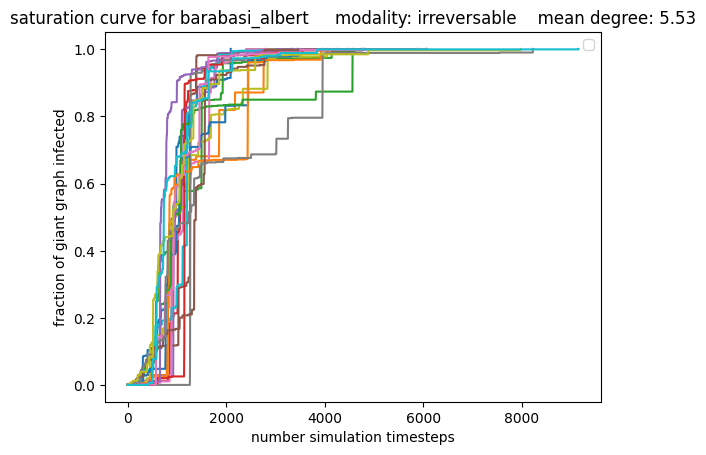

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


dropping run number 1 due to insufficient nodes in the giant component
dropping run number 2 due to insufficient nodes in the giant component
dropping run number 6 due to insufficient nodes in the giant component
dropping run number 9 due to insufficient nodes in the giant component
dropping run number 12 due to insufficient nodes in the giant component
dropping run number 18 due to insufficient nodes in the giant component
dropping run number 20 due to insufficient nodes in the giant component
dropping run number 21 due to insufficient nodes in the giant component
dropping run number 24 due to insufficient nodes in the giant component
dropping run number 25 due to insufficient nodes in the giant component
average num nodes 751.05 std :  1.6575584454250776


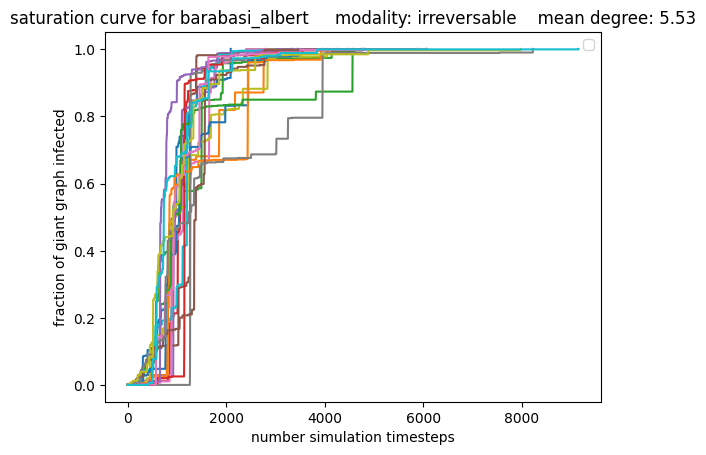

In [15]:
for mode in simulation_run: 
    plot_results(mode, graph_name)
    #print(mode)

Text(-3.6805555555555554, 0.5, 'count density')

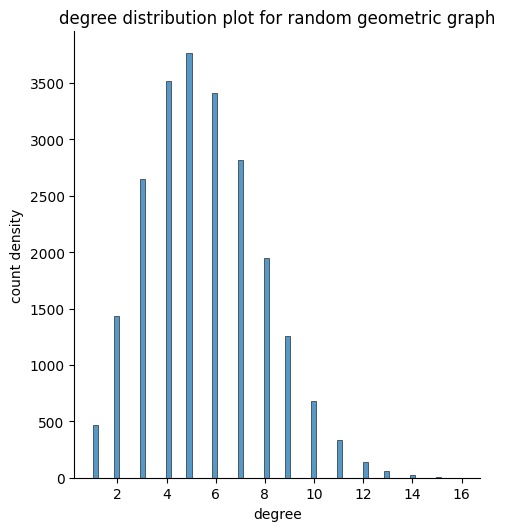

In [9]:
degrees_list = []
for run in simulation_run[0]['info_dict']:
    degrees_list.extend(run['degree_list'])

sns.displot(degrees_list)
plt.title("degree distribution plot for random geometric graph")
plt.xlabel("degree")
plt.ylabel("count density")

IRREVERSABLE GEOMETRIC GRAPH SIMULATION

In [10]:
graph_name = "barabasi_albert"
for degree in geometric_graph_conf['mean_degrees']: 
    print(f"simulation run for mean degree {degree}")
    simulation_run_barbassi = run_simulation(degree, graph_name)

simulation run for mean degree 5


100%|██████████| 30/30 [03:57<00:00,  7.93s/it]


In [13]:
for mode in simulation_run_barbassi:
    print([mode['info_dict'][x]['average_degree'] for x in range(len(simulation_run[0]['info_dict']))], "\n")

[5.976, 5.976, 5.976, 5.976, 5.976, 5.976, 5.976, 5.976, 5.976, 5.976, 5.976, 5.976, 5.976, 5.976, 5.976, 5.976, 5.976, 5.976, 5.976, 5.976, 5.976, 5.976, 5.976, 5.976, 5.976, 5.976, 5.976, 5.976, 5.976, 5.976] 

[5.976, 5.976, 5.976, 5.976, 5.976, 5.976, 5.976, 5.976, 5.976, 5.976, 5.976, 5.976, 5.976, 5.976, 5.976, 5.976, 5.976, 5.976, 5.976, 5.976, 5.976, 5.976, 5.976, 5.976, 5.976, 5.976, 5.976, 5.976, 5.976, 5.976] 

[5.976, 5.976, 5.976, 5.976, 5.976, 5.976, 5.976, 5.976, 5.976, 5.976, 5.976, 5.976, 5.976, 5.976, 5.976, 5.976, 5.976, 5.976, 5.976, 5.976, 5.976, 5.976, 5.976, 5.976, 5.976, 5.976, 5.976, 5.976, 5.976, 5.976] 



No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


average num nodes 750.0 std :  0.0


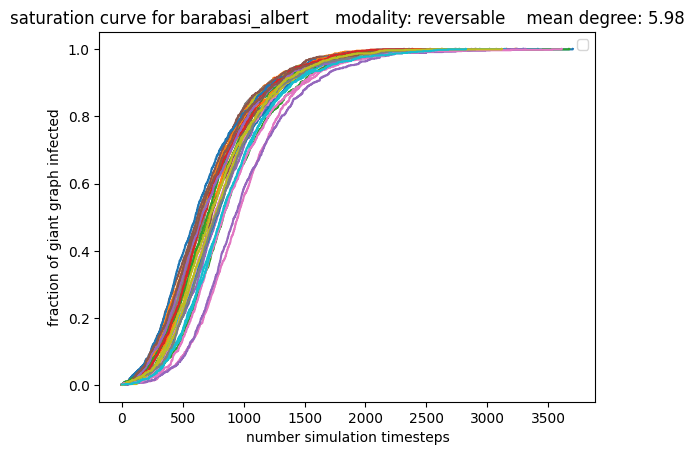

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


average num nodes 750.0 std :  0.0


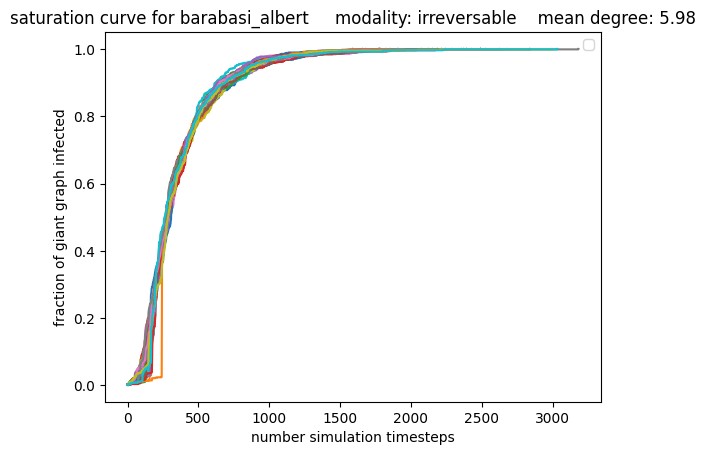

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


average num nodes 750.0 std :  0.0


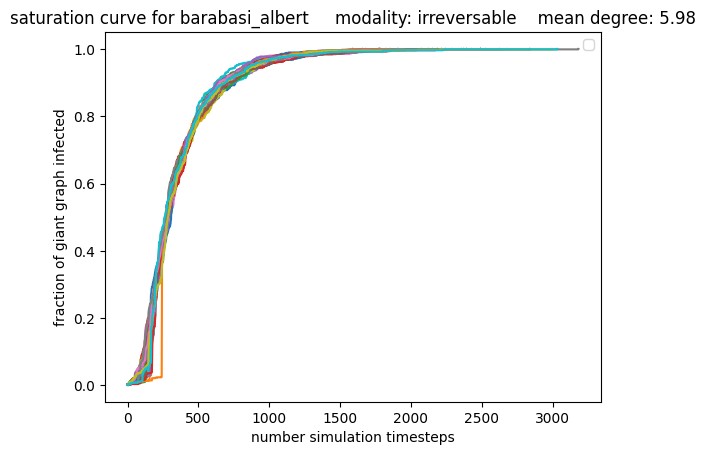

In [11]:
for mode in simulation_run_barbassi: 
    plot_results(mode, graph_name)

Text(-3.6805555555555554, 0.5, 'count density')

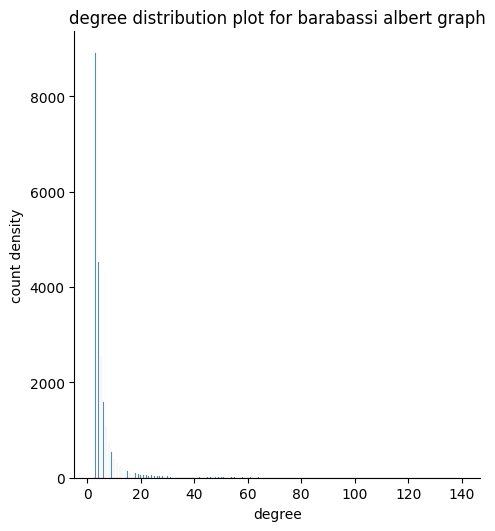

In [14]:
degrees_list = []
for run in simulation_run_barbassi[0]['info_dict']:
    degrees_list.extend(run['degree_list'])

sns.displot(degrees_list)
plt.title("degree distribution plot for barabassi albert graph")
plt.xlabel("degree")
plt.ylabel("count density")

Results for reversable albert simulation 